In [11]:
import numpy as np
from scipy.interpolate import BarycentricInterpolator
from scipy.integrate import quad
from scipy.stats import norm
from chebyshev_interpolator_sj import ChebyshevInterpolation
from Option_sj import OptionType
from quadrature_nodes_sj import QuadratureNodes
from utils import QDplus

## Define Variables to being with
l = 5
n =5
max_tau =1 
strike = 100
riskfree = 0.025
dividend = 0.025
volatility = 0.25
option_type = OptionType.Put
X = strike*min(1,riskfree/dividend)
initial_boundary = np.zeros(n+1)

cheby = ChebyshevInterpolation(5,1)
cheby.compute_nodes()
tau_nodes = cheby.tau_nodes

## 2. compute the Quadrature nodes and weights
quadrature = QuadratureNodes(l)
quadrature.compute_legendre_nodes()
y_nodes, w_weights = quadrature.get_nodes_and_weights()

## 3. compute initial boundary using QD Plus
a=QDplus(riskfree, dividend, volatility, strike, option_type)
for i in range(len(tau_nodes)):
    initial_boundary[i] = a.compute_exercise_boundary(tau_nodes[i])

###  compute q(_initial_boundary), since H_x = q_z           # Perhaps can be put to Utils 
def B_to_q(_initial_boundary):
    """
    Compute H(sqrt(tau)) for each collocation point based on the previous boundary values.

    Returns:
    - H_values (numpy array): The computed H(sqrt(tau)) values.
    """
    q_values = np.square((np.log(_initial_boundary / X)))

    return q_values

## compute b(_q_values) to obtain the reverse                # Perhaps can be put to Utils 
def q_to_B(_q_values):
    """
    Given that H_values = q
    From q/H_values calculate B

    Returns:
    - B_values (numpy array): The computed B(tau) values.
    """
    B_values = np.zeros(len(_q_values))
    for i in range(len(_q_values)):
        if _q_values[i] < 1: ### When q_value is less than 1 it means that log(B(tau)/X) was negative value
            B_values[i] = X * np.exp(-np.sqrt(_q_values[i]))
        else:
            B_values[i] = X * np.exp(np.sqrt(_q_values[i]))

    return B_values

## 4.1 initialize_chebyshev_interpolation to compute coefficients a_k
# Here do note n is 5 and we need to have n+1 nodes 
def Cheby_interpolant(q):
    a = np.zeros(n + 1)
    for k in range(n + 1):
        ans = 0
        for i in range(n + 1):
            term = q[i] * np.cos(i * k * np.pi / n)
            if i == 0 or i == n:
                term *= 0.5
            ans += term
        ans *= (2.0 / n)
        a[k] = ans
    return a

def clenshaw_algorithm(z, a_coefficients):
    """
    Evaluate the Chebyshev polynomial using Clenshaw's algorithm.

    Parameters:
    - z (float): The input value to evaluate the polynomial.

    Returns:
    - (float): The evaluated value of the Chebyshev polynomial.
    """
    b0 = a_coefficients[n] * 0.5
    b1 = 0
    b2 = 0

    for k in range(n - 1, -1, -1):
        b1, b2 = b0, b1
        b0 = a_coefficients[k] + 2 * z * b1 - b2
    return 0.5 * (b0 - b2)


In [12]:
## Define Variables to being with
l = 5
n =5
max_tau =1 
strike = 100
riskfree = 0.025
dividend = 0.025
volatility = 0.25
option_type = OptionType.Put
X = strike*min(1,riskfree/dividend)


In [13]:
## 1. Obtain Chebyshev nodes to begin
cheby = ChebyshevInterpolation(n,1)
cheby.compute_nodes()
tau_nodes = cheby.get_nodes()[1]

## Fill up rest of the variables
initial_boundary = np.zeros(n+1)

## print tau_nodes
tau_nodes

array([1.        , 0.81813562, 0.42838137, 0.11936438, 0.00911863,
       0.        ])

In [14]:
## 2. compute the Quadrature nodes and weights
quadrature = QuadratureNodes(l)
quadrature.compute_legendre_nodes()
y_nodes, w_weights = quadrature.get_nodes_and_weights()

In [15]:
## 3. compute initial boundary using QD Plus
a=QDplus(riskfree, dividend, volatility, strike, option_type) 
for i in range(len(tau_nodes)):
    initial_boundary[i] = a.compute_exercise_boundary(tau_nodes[i])

In [16]:
## compute q(_initial_boundary), since H_x = q_z 
def B_to_q(_initial_boundary):
    """
    Compute H(sqrt(tau)) for each collocation point based on the previous boundary values.

    Returns:
    - H_values (numpy array): The computed H(sqrt(tau)) values.
    """
    q_values = (np.log(_initial_boundary / X)) ** 2 

    return q_values

## compute b(_q_values) to obtain the reverse 
def q_to_B(_q_values):
    """
    Given that H_values = q
    From q/H_values calculate B

    Returns:
    - B_values (numpy array): The computed B(tau) values.
    """
    B_values = np.zeros(len(_q_values))
    for i in range(len(_q_values)):
        if _q_values[i] < 1: ### When q_value is less than 1 it means that log(B(tau)/X) was negative value
            B_values[i] = X * np.exp(-np.sqrt(_q_values[i]))
        else:
            B_values[i] = X * np.exp(np.sqrt(_q_values[i]))

    return B_values



In [17]:
## Test to interpolate the original points

a_coefficients = Cheby_interpolant(B_to_q(initial_boundary)) # obtain a_coefficients that will be used for interpolation

### Test for Clenshaw for inpterolation by ensuring that q(zi) can be obtained for the given zi of the intial boundary 

q = B_to_q(initial_boundary) # obtain the H_values (or q values) from intial boundary
z_i = cheby.z_nodes # obtain the z_i that we will try to interpolate


for i in range(len(z_i)):
    print(q[i], max(clenshaw_algorithm(z_i[i], a_coefficients),0))

0.2271734595026403 0.22717345950264034
0.19845093079156076 0.19845093079156076
0.12619720456489988 0.1261972045648999
0.048513710245540284 0.0485137102455403
0.005990050719278804 0.005990050719278793
0.0 0


In [21]:
## 4.1 initialize_chebyshev_interpolation to compute coefficients a_k
"""
Initialize the Chebyshev interpolation by computing the coefficients a_k.
"""
def Cheby_interpolant(_q):
    a = np.zeros(n + 1)
    for k in range(n + 1):
        ans = 0
        for i in range(n + 1):
            term = q[i] * np.cos(i * k * np.pi / n)
            if i == 0:
                term *= 0.5
            elif i == n:
                term *= ((-1)**n)*0.5
            ans += term
        ans *= (2.0 / n)
        a[k] = ans
    return a

    return a

In [24]:
def clenshaw_algorithm(z, a_coefficients):
    b0 = a_coefficients[n] * 0.5
    b1 = 0
    b2 = 0

    for k in range(n - 1, -1, -1):
        b1, b2 = b0, b1
        b0 = a_coefficients[k] + 2 * z * b1 - b2
    return 0.5 * (b0 - b2)

In [26]:
### Test for Clenshaw for inpterolation by ensuring that I can obtain q(zi) for the given zi of the intial boundary 

q = B_to_q(initial_boundary) # obtain the q from intial boundary
z_i = cheby.z_nodes # obtain the z_i that we will try to interpolate

test_a_coefficients = Cheby_interpolant(B_to_q(initial_boundary)) # obtain a_coefficients that will be used for interpolation

for i in range(len(z_i)):
    print(q[i], max(clenshaw_algorithm(z_i[i], a_coefficients),0))

0.2271734595026403 0.22717345950264034
0.19845093079156076 0.19845093079156076
0.12619720456489988 0.1261972045648999
0.048513710245540284 0.0485137102455403
0.005990050719278804 0.005990050719278793
0.0 0


C:\Users\sengj\AppData\Local\Temp\ipykernel_20736\2396343532.py:25: RuntimeWarning: invalid value encountered in sqrt
  B_values[i] = X * np.exp(-np.sqrt(_q_values[i]))


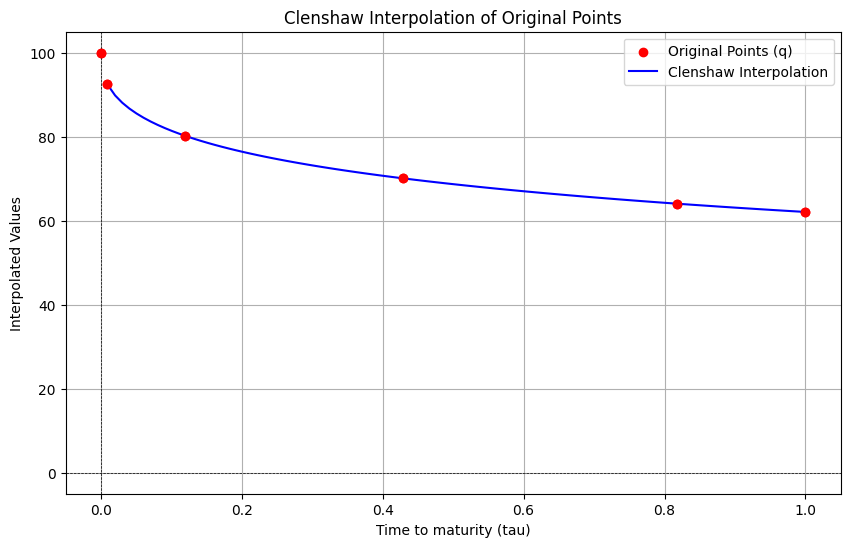

In [27]:
###### Test for the smoothness of the Interpolation 

import matplotlib.pyplot as plt
# Generate points for interpolation
x_values = np.linspace(0, max_tau, 100)  # 100 points between min and max of tau_i
z_values = ((np.sqrt(x_values)*2)/(np.sqrt(max(tau_nodes))))-1
interpolated_values = [clenshaw_algorithm(x, a_coefficients) for x in z_values]

interpolated_values = q_to_B(interpolated_values)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot original points
plt.scatter(tau_nodes, initial_boundary, color='red', label='Original Points (q)', zorder=5)
plt.plot(tau_nodes, initial_boundary, 'ro')  # Optionally draw lines connecting original points

# Plot interpolated values
plt.plot(x_values, interpolated_values, label='Clenshaw Interpolation', color='blue')

# Add labels and title
plt.title('Clenshaw Interpolation of Original Points')
plt.xlabel('Time to maturity (tau)')
plt.ylabel('Interpolated Values')
plt.axhline(0, color='black', linewidth=0.5, ls='--')  # Add horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.5, ls='--')  # Add vertical line at x=0
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [32]:
## 4.3 Def Interpolation scheme to be used for quadrature later
# This means that we would be obtaining for tau - tau(1+y)**2/4

def evaluate_boundary(tau, y_nodes, a_coefficients):

    ## For each tau we hope to obtain a series of nodes
    qz_interpolated = np.zeros(len(y_nodes))
    
    # Use the quadrature nodes obtained in the quadacture earlier
    for k, y_k in enumerate(y_nodes):
        adjusted_tau = tau - tau * (1 + y_k)**2 / 4               # Obtain the adjusted tau for each y_k, but the adjusted tau cannot be negative
        z = 2 * np.sqrt(adjusted_tau / max_tau) - 1             # From the tau obtain the z value
        qz_interpolated[k] = max(clenshaw_algorithm(z, a_coefficients),0) # Interpolate qz using the clenshaw algorithm

    B_values = q_to_B(qz_interpolated)                                    # q(z) = H(xi) to back out B_value for the z

    return B_values

In [33]:
## Test Evaluate Boudary

for tau in tau_nodes:
    print(evaluate_boundary(tau, y_nodes, a_coefficients))

[62.10899705 62.62409379 64.89484897 70.52644006 81.99907998]
[64.07322496 64.58317356 66.80917465 72.26902085 83.26065742]
[70.1199491  70.58519098 72.59971802 77.47138612 86.85671305]
[80.24636743 80.60661848 82.14808983 85.73285894 92.00306561]
[92.55879663 92.71006341 93.34339327 94.73552906 96.95755745]
[100. 100. 100. 100. 100.]


In [34]:
# Before Calculating the Integrand ensure that d1 and d2 can be calculated / Also in the option class
# riskfree, dividend, strike, volatility should be defined externally, so the funciton depends only on tau and s0
def d1(tau, z):
    return (np.log(z) + (riskfree - dividend)*tau + 0.5 * volatility * volatility * tau)/(volatility * np.sqrt(tau))

def d2(tau, z):
    return (np.log(z) + (riskfree - dividend)*tau - 0.5 * volatility * volatility * tau)/(volatility * np.sqrt(tau))

In [35]:
# Obtain K1 for each tau(i)

def K1_integrad (tau, B, yk_nodes, B_y):
    k = len(yk_nodes)
    K1integrads = np.zeros(k)

    for i,yk in enumerate(yk_nodes):
        term0 = 0.25 * tau * (1 + yk)**2
        term1 = np.exp(-dividend * term0)
        term2 = (1 + yk)
        term3 = norm.cdf(d1(term0, B / interpolate_tau(tau - term0)))
        # Debugging prints
        K1integrads[i] = term1 * term2 * term3
    return K1integrads


def K1(tau, B_tau, yk, wk):
    B_yk = evaluate_boundary(tau, yk, a_coefficients)
    integrad = K1_integrad(tau, B_tau, y_nodes, B_yk)
    return tau*np.exp(dividend*tau)*0.5*sum(integrad*w_weights)



In [36]:
def K2_integrad (tau, B_tau, yk_nodes, B_y):
    k = len(yk_nodes)
    K2integrads = np.zeros(k)
   
    for i in range(k):
        term0 = tau / 4 * (1 + yk_nodes[i])**2
        term1 = (np.exp(-dividend * term0))/volatility
        term2 = norm.pdf(d1(term0, B_tau/B_y[i]))
        K2integrads[i] = term1*term2
    return K2integrads

def K2(tau, B_tau, y_nodes, w_weights):
    B_yk = evaluate_boundary(tau, y_nodes, a_coefficients)
    integrad = K2_integrad(tau, B_tau, y_nodes, B_yk)
    return tau*np.exp(dividend*tau)*sum(integrad*w_weights)

In [37]:
def K3_integrand(tau, B_tau, yk_nodes, B_y):
    k = len(yk_nodes)
    K3integrads = np.zeros(k)

    for i in range(k):
        term0 = 0.25 * tau *(1 + yk_nodes[i])**2
        term1 = (np.exp(-riskfree * term0))/volatility
        term2 = norm.pdf(d2(term0, B_tau/B_y[i]))
        K3integrads[i] = term1*term2
    return K3integrads

def K3(tau, B_tau, y_nodes, w_weights):
    B_yk = evaluate_boundary(B_tau, y_nodes, a_coefficients)
    integrad = K3_integrand(tau, B_tau, y_nodes, B_yk)
    return tau*np.exp(riskfree*tau)*sum(integrad*w_weights)

In [39]:
def N(tau, Beta):
    return norm.pdf(d2(tau, Beta/strike))/(volatility*np.sqrt(tau)) + riskfree*K3(tau, Beta, y_nodes, w_weights)

def D(tau, Beta):
    return norm.cdf(d1(tau,Beta/strike)) + norm.pdf(d1(tau, Beta/strike))/(volatility*np.sqrt(tau)) + dividend*(K1(tau, Beta,y_nodes, w_weights) + K2(tau, Beta,y_nodes, w_weights))

def f(tau,Beta):
    strike*np.exp(-(riskfree-dividend)*tau)*N(tau,Beta,y_nodes, w_weights)/D(tau,Beta,y_nodes, w_weights)

## Approximation of NPrime
def Nprime(tau,B):
    return -d2(tau, B/strike) * norm.pdf(d2(tau, B/strike)) / (B * volatility * volatility * tau)

## Approximation of DPrime
def DPrime(tau,B):
    return -d2(tau, B/strike) * norm.pdf(d1(tau, B/strike)) / (B * volatility * volatility * tau)

def fprime(tau,B):
    strike*np.exp(-(riskfree-dividend)*tau)*(Nprime(tau,B)/D(tau,B) - DPrime(tau,B)*N(tau,B)/(D(tau,B)**2))

In [40]:
N(tau_nodes[1], initial_boundary[1])

0.20271452378574326